## Goal:
Inspect behavior of voters as a function of object parameters. Also look at some images to figure out whether or not voter behavior makes sense.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from datetime import date

import sys
sys.path.append('..')
from sf import make_df_tasks_with_props, make_df_vote_threshold

%matplotlib inline

In [2]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf
reload(sf)

<module 'sf' from '..\\sf.py'>

In [5]:
# set matplotlib plotting params:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

In [3]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')
answer_types = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

In [7]:
df = pd.read_csv('./df.csv', delimiter=',')
df_props = make_df_tasks_with_props(df, candidate_names_classify, object_info)

---

In [13]:
# copy-paste object props for possible later use
props = ['RA', 'DEC', 'Reff', 'r_mag', 'g_mag', 'axis_ratio', 'pos_angle', 'n', 'u', 'g', 'r', 'i', 'ue', 'ge',
       're', 'ie', 'Reffe', 'r_mage', 'ne', 'C', 'mue_r', 'bae', 'RFF']

## Inspect objects without props (these are presumably artifacts)

In [36]:
answers = list(
    map(lambda x: '% votes {}'.format(x), ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center'])
)

In [25]:
no_props = df_props[df_props['RA'].isnull()]

print('# objects without properties: {}'.format(no_props.shape[0]))

# objects without properties: 922


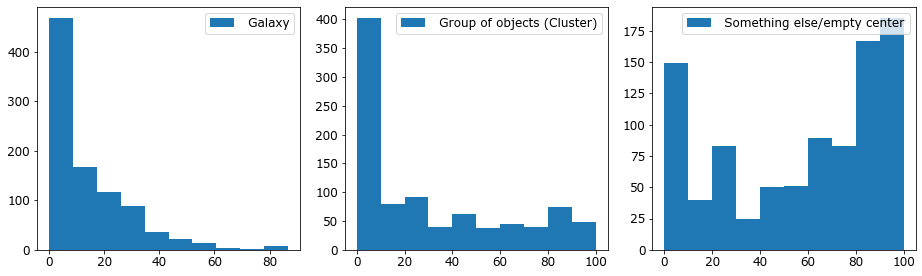

In [61]:
name, gal, group, empty = no_props[['name', *answers]]

fig, fr = plt.subplots(1,3, figsize=(13,4))

for i in range(3):
    fr[i].hist(no_props[answers[i]], label=answers[i][7:])
    fr[i].legend()
    
fig.tight_layout()
plt.show()